In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams

plt.style.use('ggplot')
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)

From the EDA notebook, we found that zipcode 19121 was one of the top 5 zipcodes. We are going to forecast future home values in zipcode 19121 in this notebook.

In [24]:
df = pd.read_csv('zillow_data.csv')
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,329121.0,334059.0,338019.0,346657.0,354457.0,361917.0,369769.0,376112.0,381673.0,386586.0,394154.0,402687.0,412006.0,420541.0,429242.0,436291.0,442139.0,447655.0,452725.0,457455.0,461020.0,465658.0,469811.0,475268.0,478912.0,482464.0,484481.0,488259.0,493127.0,499165.0,503717.0,507932.0,511068.0,514280.0,518252.0,522487.0,527352.0,531284.0,535317.0,539349.0,549450.0,567133.0,588505.0,605851.0,613242.0,617110.0,619549.0,625388.0,631255.0,636089.0,639742.0,643306.0,647193.0,652314.0,659961.0,669842.0,683972.0,696806.0,708743.0,716797.0,728843.0,739511.0,759399.0,771571.0,785979.0,795559.0,805064.0,814587.0,817033.0,832764.0,850933.0,876511.0,901911.0,921178.0,927869.0,922251.0,924475.0,931610.0,934145.0,909286.0,874103.0,840213.0,841253.0,864029.0,878088.0,880955.0,875206.0,881249.0,884836.0,877242.0,872894.0,865069.0,888219.0,909058.0,932691.0,932638.0,933780.0,929386.0,935242.0,949011.0,950769.0,940471.0,901618.0,887671.0,894583.0,898397.0,891086.0,854973.0,823871.0,7

In [25]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[9:], format='%Y-%m')

In [26]:
df.columns = list(df.columns[:9]) + list(get_datetimes(df))

In [27]:
#Only rows within the top states of the northeast US
df = df[df['State'].isin(['NY', 'PA', 'NJ', 'MA', 'CT'])]
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,2000-06-30 00:00:00,2000-07-31 00:00:00,2000-08-31 00:00:00,2000-09-30 00:00:00,2000-10-31 00:00:00,2000-11-30 00:00:00,2000-12-31 00:00:00,2001-01-31 00:00:00,2001-02-28 00:00:00,2001-03-31 00:00:00,2001-04-30 00:00:00,2001-05-31 00:00:00,2001-06-30 00:00:00,2001-07-31 00:00:00,2001-08-31 00:00:00,2001-09-30 00:00:00,2001-10-31 00:00:00,2001-11-30 00:00:00,2001-12-31 00:00:00,2002-01-31 00:00:00,2002-02-28 00:00:00,2002-03-31 00:00:00,2002-04-30 00:00:00,2002-05-31 00:00:00,2002-06-30 00:00:00,2002-07-31 00:00:00,2002-08-31 00:00:00,2002-09-30 00:00:00,2002-10-31 00:00:00,2002-11-30 00:00:00,2002-12-31 00:00:00,2003-01-31 00:00:00,2003-02-28 00:00:00,2003-03-31 00:00:00,2003-04-30 00:00:00,2003-05-31 00:00:00,2003-06-30 00:00:00,2003-07-31 00:00:00,2003-08-31 00:00:00,2003-09-30 00:00:00,2003-10-31 00:00:00,2003-11-30 00:00:00,2003-12-31 00:00:00,2004-01-31 00:00:00,2004-02-29 00:00:00,2004-03-31 00:00:00,2004-04-30 00:00:00,2004-05-31 00:00:00,2004-06-30 00:00:00,2004-07-31 00:00:00,2004-08-31 00:00:00,2004-09-30 00:00:00,2004-10-31 00:00:00,2004-11-30 00:00:00,2004-12-31 00:00:00,2005-01-31 00:00:00,2005-02-28 00:00:00,2005-03-31 00:00:00,2005-04-30 00:00:00,2005-05-31 00:00:00,2005-06-30 00:00:00,2005-07-31 00:00:00,2005-08-31 00:00:00,2005-09-30 00:00:00,2005-10-31 00:00:00,2005-11-30 00:00:00,2005-12-31 00:00:00,2006-01-31 00:00:00,2006-02-28 00:00:00,2006-03-31 00:00:00,2006-04-30 00:00:00,2006-05-31 00:00:00,2006-06-30 00:00:00,2006-07-31 00:00:00,2006-08-31 00:00:00,2006-09-30 00:00:00,2006-10-31 00:00:00,2006-11-30 00:00:00,2006-12-31 00:00:00,2007-01-31 00:00:00,2007-02-28 00:00:00,2007-03-31 00:00:00,2007-04-30 00:00:00,2007-05-31 00:00:00,2007-06-30 00:00:00,2007-07-31 00:00:00,2007-08-31 00:00:00,2007-09-30 00:00:00,2007-10-31 00:00:00,2007-11-30 00:00:00,2007-12-31 00:00:00,2008-01-31 00:00:00,2008-02-29 00:00:00,2008-03-31 00:00:00,2008-04-30 00:00:00,2008-05-31 00:00:00,2008-06-30 00:00:00,2008-07-31 00:00:00,2008-08-31 00:00:00,2008-09-30 00:00:00,2008-10-31 00:00:00,2008-11-30 00:00:00,2008-12-31 00:00:00,2009-01-31 00:00:00,2009-02-28 00:00:00,2009-03-31 00:00:00,2009-04-30 00:00:00,2009-05-31 00:00:00,2009-06-30 00:00:00,2009-07-31 00:00:00,2009-08-31 00:00:00,2009-09-30 00:00:00,2009-10-31 00:00:00,2009-11-30 00:00:00,2009-12-31 00:00:00,2010-01-31 00:00:00,2010-02-28 00:00:00,2010-03-31 00:00:00,2010-04-30 00:00:00,2010-05-31 00:00:00,2010-06-30 00:00:00,2010-07-31 00:00:00,2010-08-31 00:00:00,2010-09-30 00:00:00,2010-10-31 00:00:00,2010-11-30 00:00:00,2010-12-31 00:00:00,2011-01-31 00:00:00,2011-02-28 00:00:00,2011-03-31 00:00:00,2011-04-30 00:00:00,2011-05-31 00:00:00,2011-06-30 00:00:00,2011-07-31 00:00:00,2011-08-31 00:00:00,2011-09-30 00:00:00,2011-10-31 00:00:00,2011-11-30 00:00:00,2011-12-31 00:00:00,2012-01-31 00:00:00,2012-02-29 00:00:00,2012-03-31 00:00:00,2012-04-30 00:00:00,2012-05-31 00:00:00,2012-06-30 00:00:00,2012-07-31 00:00:00,2012-08-31 00:00:00,2012-09-30 00:00:00,2012-10-31 00:00:00,2012-11-30 00:00:00,2012-12-31 00:00:00,2013-01-31 00:00:00,2013-02-28 00:00:00,2013-03-31 00:00:00,2013-04-30 00:00:00,2013-05-31 00:00:00,2013-06-30 00:00:00,2013-07-31 00:00:00,2013-08-31 00:00:00,2013-09-30 00:00:00,2013-10-31 00:00:00,2013-11-30 00:00:00,2013-12-31 00:00:00,2014-01-31 00:00:00,2014-02-28 00:00:00,2014-03-31 00:00:00,2014-04-30 00:00:00,2014-05-31 00:00:00,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,2014-09-30 00:00:00,2014-10-31 00:00:00,2014-11-30 00:00:00,2014-12-31 00:00:00,2015-01-31 00:00:00,2015-02-28 00:00:00,2015-03-31 00:00:00,2015-04-30 00:00:00,2015-05-31 00:00:00,2015-06-30 00:00:00,2015-07-31 00:00:00,2015-08-31 00:00:00,2015-09-30 00:00:00,2015-10-31 00:00:00,2015-11-30 00:00:00,2015-12-31 00:00:00,2016-01-31 00:00:00,2016-02-29 00:00:00,2016-03-31 00:00:00,2016-04-30 00:00:00,2

In [28]:
#grouping the columns by years and their average price
c = df.columns.tolist()
cols = c[:9] 
cols.append(c[-1]) 
print (cols)

#set to index all NOT date columns
tdf = df.set_index(df.columns.tolist()[:9])
tdf.columns = pd.to_datetime(tdf.columns).to_period('M')

# find the columns in the period 2000-2021
cols = tdf.columns
sel_cols = cols[(cols > '2000-01') & (cols < '2022')]
print (sel_cols)


#change format columns
a = tdf[sel_cols].rename(columns=lambda x: '{:}'.format(x.year, [1]))
print (a.columns)

#groupby by a with new format
mdf = a.groupby(a.columns, axis=1).mean().reset_index()

['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName', Timestamp('2021-08-31 00:00:00')]
PeriodIndex(['2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07',
             '2000-08', '2000-09', '2000-10', '2000-11',
             ...
             '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04',
             '2021-05', '2021-06', '2021-07', '2021-08'],
            dtype='period[M]', length=259, freq='M')
Index(['2000', '2000', '2000', '2000', '2000', '2000', '2000', '2000', '2000',
       '2000',
       ...
       '2020', '2020', '2021', '2021', '2021', '2021', '2021', '2021', '2021',
       '2021'],
      dtype='object', length=259)


In [29]:
mdf['average_annual_return'] = (((mdf['2021']-mdf['2000'])/mdf['2000'])*100)
mdf['rate_year']=mdf['average_annual_return']/21
top_five = mdf.sort_values(by='rate_year', ascending=False).head(5)
top_five

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,average_annual_return,rate_year
2855,58807,16737,2558,Zip,MA,MA,Wareham,Boston-Cambridge-Newton,Plymouth County,36981.818182,46860.750000,58951.166667,73839.583333,81465.333333,91191.083333,98618.500000,90287.416667,90895.416667,81423.500000,81278.916667,81293.000000,84706.583333,109882.416667,136346.750000,1.623931e+05,1.896925e+05,2.189622e+05,2.584022e+05,2.676696e+05,3.246265e+05,366638.625,891.402378,42.447732
92,62027,516,11216,Zip,NY,NY,New York,New York-Newark-Jersey City,Kings County,159543.000000,186038.166667,220661.500000,268010.916667,313416.416667,377583.333333,460031.750000,522687.083333,541119.583333,471203.166667,456315.666667,465404.083333,507982.166667,613773.833333,814626.583333,9.696168e+05,1.058784e+06,1.076584e+06,1.145235e+06,1.144215e+06,1.145505e+06,1152785.125,622.554499,29.645452
708,65789,5379,19122,Zip,PA,PA,Philadelphia,Philadelphia-Camden-Wilmington,Philadelphia County,43344.909091,49257.500000,60191.916667,73493.833333,92622.500000,107774.916667,136895.916667,160958.416667,155417.500000,164019.416667,167015.916667,158536.416667,145589.583333,161409.416667,167096.083333,1.783024e+05,1.789871e+05,2.031756e+05,2.369558e+05,2.594141e+05,2.750910e+05,295731.375,582.274761,27.727370
227,65788,1572,19121,Zip,PA,PA,Philadelphia,Philadelphia-Camden-Wilmington,Philadelphia County,36210.818182,41512.083333,42839.500000,47378.500000,58035.166667,77900.916667,97453.083333,113018.166667,103451.750000,100302.583333,93118.083333,79137.750000,62845.750000,73558.916667,81038.500000,9.014233e+04,9.106808e+04,1.119107e+05,1.495841e+05,1.782407e+05,2.029722e+05,236809.125,553.973417,26.379687
183,62033,1187,11222,Zip,NY,NY,New York,New York-Newark-Jersey City,Kings County,179628.636364,222675.416667,298888.750000,360174.833333,421157.666667,573325.750000,654414.833333,663559.750000,641443.416667,582575.250000,563242.000000,573196.083333,618760.000000,737275.833333,876103.333333,1.011760e+06,1.054034e+06,1.063602e+06,1.078892e+06,1.085332e+06,1.087756e+06,1096991.500,510.699676,24.319032


In [30]:
#getting the list of zipcodes
values = set(top_five['RegionID'])
#getting them in our old dateFrame
df_new = df[df['RegionID'].isin([58807, 62027, 62033, 65788, 65789])]

In [31]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [32]:
df_11216 = df_new[df_new['RegionName']==11216]
df_11222 = df_new[df_new['RegionName']==11222]
df_19121 = df_new[df_new['RegionName']==19121]
df_19122 = df_new[df_new['RegionName']==19122]
df_2558  = df_new[df_new['RegionName']==2558]

In [33]:
df_11216 = melt_data(df_11216)
df_11222= melt_data(df_11222)
df_19121= melt_data(df_19121)
df_19122= melt_data(df_19122)
df_2558= melt_data(df_2558)

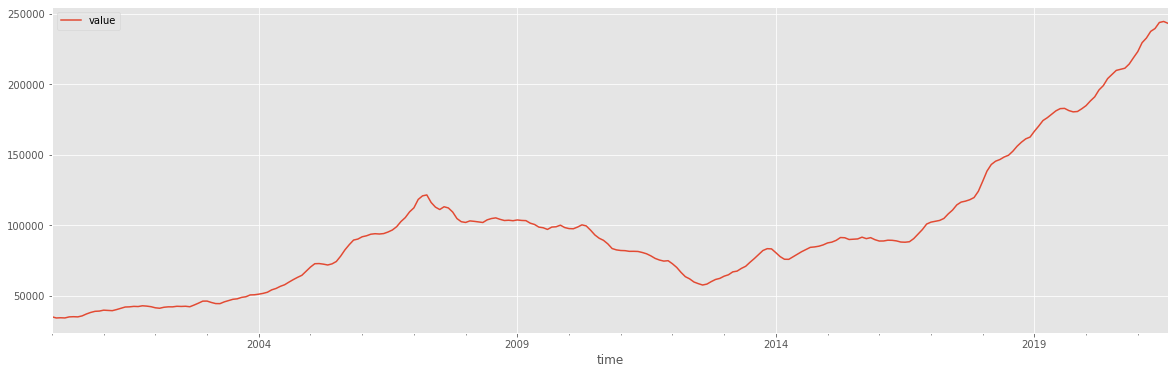

In [34]:
df_19121.plot(figsize=(20,6));

# Baseline Model

In [35]:
naive = df_19121.shift(1)
naive

,value
time,
2000-01-31,NaN
2000-02-29,35211.0
2000-03-31,34351.0
2000-04-30,34498.0
2000-05-31,34373.0
...,...
2021-04-30,232825.0
2021-05-31,237570.0
2021-06-30,239566.0


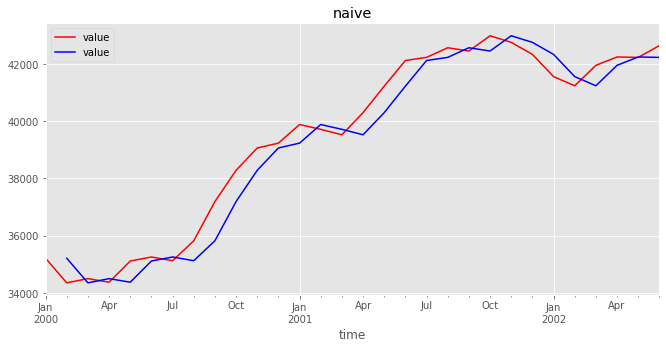

In [36]:
fig, ax = plt.subplots(figsize=(11, 5))

df_19121[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [37]:
dftest = adfuller(naive.dropna())
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.164207
p-value                          0.970181
#Lags Used                      13.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


# Modeling

In [38]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(df_19121)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print('19121')
print(dfoutput)

Results of Dickey-Fuller Test: 

19121
Test Statistic                   0.034223
p-value                          0.961272
#Lags Used                      14.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


# Check Seaonality

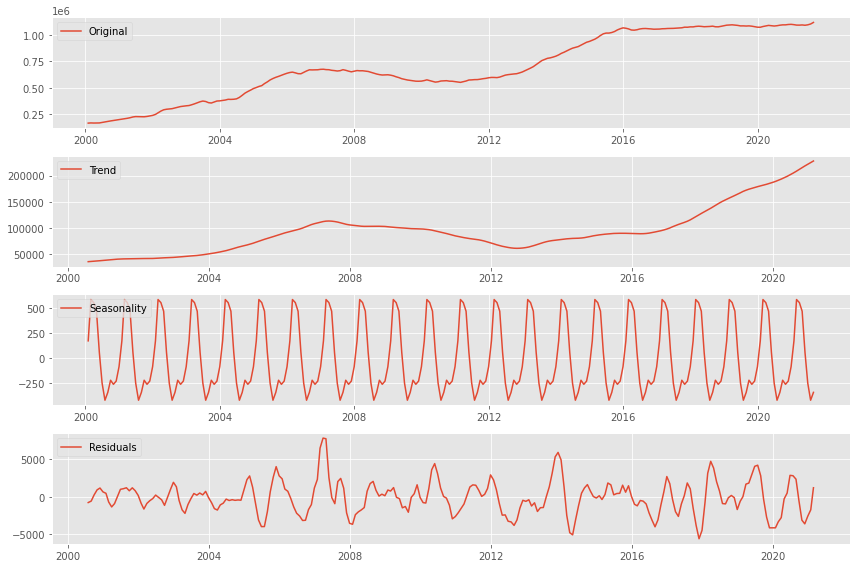

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(df_19121)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_11222, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()


This model has an upward trend with seasonality as well 

# Differencing

We can try to make our model stationary by taking the difference

In [40]:
diff = df_19121.diff().diff().dropna()

dftest = adfuller(diff)
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -8.140698e+00
p-value                        1.030078e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64



Taking two difference makes our p-value < 0.05. Let's look at autocorrelation.

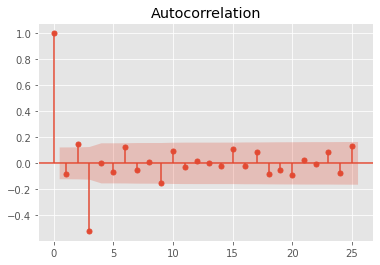

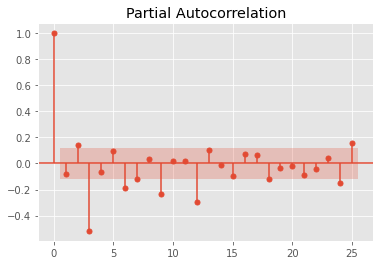

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation Plot
plot_acf(df_19121.diff().diff().dropna());

# Partial Autocorrelation Plot
plot_pacf(df_19121.diff().diff().dropna());

<AxesSubplot:xlabel='time'>

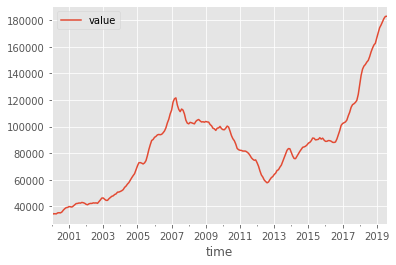

In [42]:
df_19121_train =df_19121[:236]
df_19121_test = df_19121[236:] 
df_19121_train.plot()

# Rolling Mean

<AxesSubplot:xlabel='time'>

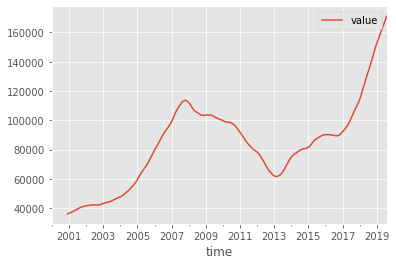

In [43]:
df_19121_train.rolling(12).mean().plot()

# First Order difference

<AxesSubplot:xlabel='time'>

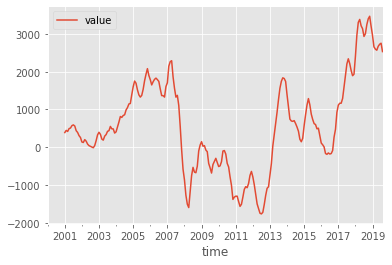

In [44]:
df_19121_train.diff(periods=1).rolling(12).mean().plot()

# Second Order Difference

<AxesSubplot:xlabel='time'>

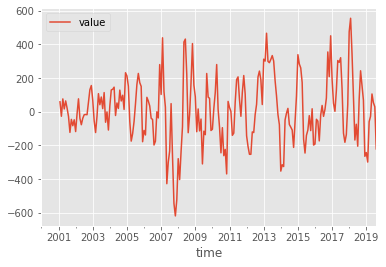

In [45]:
df_19121_train.diff().diff().rolling(12).mean().plot()

In [46]:
# Fit a SARIMAX model on the data set with a first order difference.

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [48]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

sm = SARIMAX(endog=df_19121_train, order =(0,1,0)).fit()

In [49]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(df_19121_train, sm.predict(), squared=False)
rmse

3001.5705267607227

# SARIMAX

To get the best hyperparameters for our model, we created a combination of orders and seasonal orders in the range of 0-2, inclusive.



In [50]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [55]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(df_19121,
                        order=comb,
                        seasonal_order=combs,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =6741.45398736851
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6284.17920880073
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =5880.746015525703
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5550.657369665099
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5228.791895054726
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =4947.403663550744
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =5167.087703364629
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =4896.631101749261
ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =4641.500939376105
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5463.048069478534
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5405.1819306743
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =5144.124824439587
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5169.205836162521
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =5147.560687011473
ARIMA (0, 0, 0) x (1, 1,

ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4314.714275362878
ARIMA (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =4111.584139034914
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4189.900762682904
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4128.786283108937
ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3919.2955605425423
ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4156.77329632984
ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3977.2844808460195
ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3862.525527641641
ARIMA (0, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =4145.825874739242
ARIMA (0, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =4145.713803007171
ARIMA (0, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =4113.584049667933
ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3957.0553676383956
ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3955.1377629517124
ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3919.5323340650193
ARIMA (0, 1, 1) 

ARIMA (0, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =4035.320051097665
ARIMA (0, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =3986.9939444698775
ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3888.647545912889
ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3879.209550418345
ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3817.3777571632922
ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3806.5791140503325
ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3731.463689836189
ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3683.50548569783
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =4630.617863084926
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4420.9468438734075
ARIMA (1, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =4299.883011227674
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4535.079581218496
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4814.675085975203
ARIMA (1, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =4048.845914284514
ARIMA (1, 0, 0) x

ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =4015.8965627710368
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4344.1101887887
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4060.2360204934184
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3845.4841648984584
ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4386.719431266631
ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3962.7757575409396
ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3708.1849955390517
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4227.107393241784
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4212.7616828925875
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =4016.4976803888285
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4110.323518390484
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4062.1848237541944
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3840.702573913023
ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4101.580720247673
ARIMA (1, 1, 1

ARIMA (1, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =3915.874383726562
ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4092.844742070492
ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3967.6601290427275
ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3751.447628263981
ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4103.606777648411
ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3897.3773687518496
ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3638.367665177141
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =3947.612894678978
ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =3949.5934761839717
ARIMA (1, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =3929.4542290036193
ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3849.086312550695
ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3787.0568918927675
ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3769.5830914372946
ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3771.630884836002
ARIMA (1, 2, 2

ARIMA (2, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated =4018.2401664101676
ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3848.674664532443
ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3848.183471417506
ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3848.1785807633164
ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3761.4296953858343
ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3696.6662758763737
ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3696.411313781097
ARIMA (2, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =4407.990683016484
ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4210.911755526107
ARIMA (2, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =4014.724082327681
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4343.149374287244
ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4068.3161591815597
ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3847.8451472701217
ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4367.953975060311
ARIMA (2, 1, 1

ARIMA (2, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =3904.0517330740595
ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =4301.567471429944
ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3960.435638243835
ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3741.5440565398576
ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =4324.7404903285915
ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3926.465447959238
ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3792.0957133910047
ARIMA (2, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =4110.948909383762
ARIMA (2, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =4096.94248427674
ARIMA (2, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =3904.8234537206245
ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4056.8135307806338
ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3942.218700309012
ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3740.8001834169154
ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4025.3313172465314
ARIMA (2, 2, 

In [57]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 2)
pdqs    (1, 2, 2, 12)
aic       3592.008805
Name: 152, dtype: object

From the combination, our SARIMAX model with order=(0,1,2) and seasonal_order=(1, 2, 2, 12) got the lowest aic score, which was 3592.008805

Now, we can use those hyperparameters for our final model to predict future home values.



In [58]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = SARIMAX(df_19121, 
                                        order=(0, 1, 2), 
                                        seasonal_order=(1, 2, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9999      0.190      5.274      0.000       0.628       1.372
ma.L2          0.9958      0.380      2.622      0.009       0.251       1.740
ar.S.L12       0.1659      0.039      4.248      0.000       0.089       0.242
ma.S.L12      -1.5879      0.072    -22.112      0.000      -1.729      -1.447
ma.S.L24       0.6374      0.062     10.293      0.000       0.516       0.759
sigma2      1.416e+06   5.45e+05      2.599      0.009    3.48e+05    2.48e+06


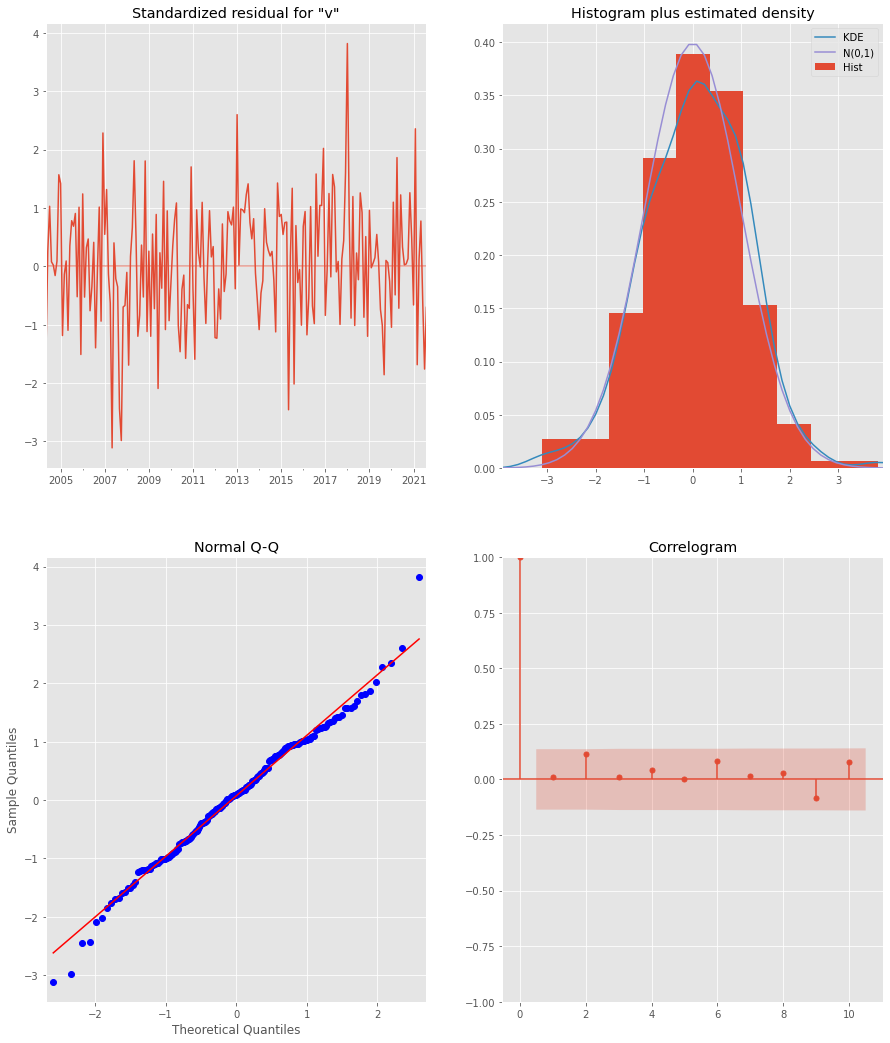

In [59]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

The first plot shows that the some residuals are normally distributed. The top right plot shows that the data seems normally distributed. The bottom left plot shows that the residuals follow the linear trend from a standard normal distribution. The bottom right plot shows that the autocorrelation.

# Validating the Model¶

We will validate the last 2 years starting from January 2019

In [60]:
# Get predictions starting from 01-31-2019 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=False)
pred_conf = pred.conf_int()

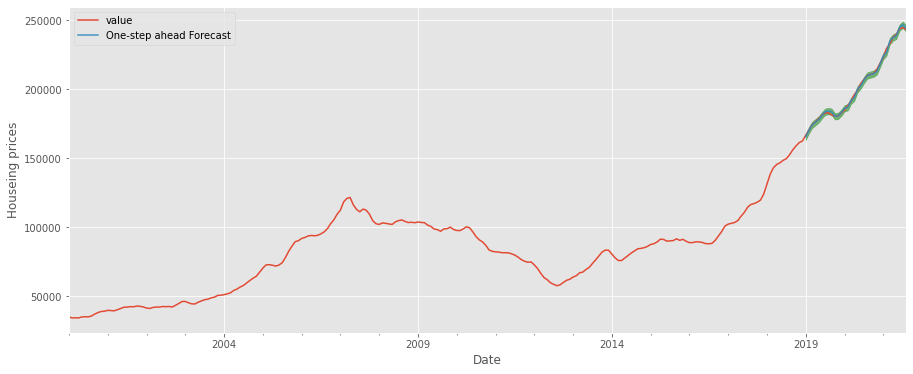

In [61]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = df_19121.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Houseing prices')
plt.legend()

plt.show()

In [62]:
# Get the real and predicted values
df19121_forecasted = pred.predicted_mean
df19121_truth = df_19121['value']['2019-01-31':]

# Compute the mean square error
mse = ((df19121_forecasted - df19121_truth) ** 2).mean()
rmse =np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 1158.01


# Dynamic Forecasting

In [63]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

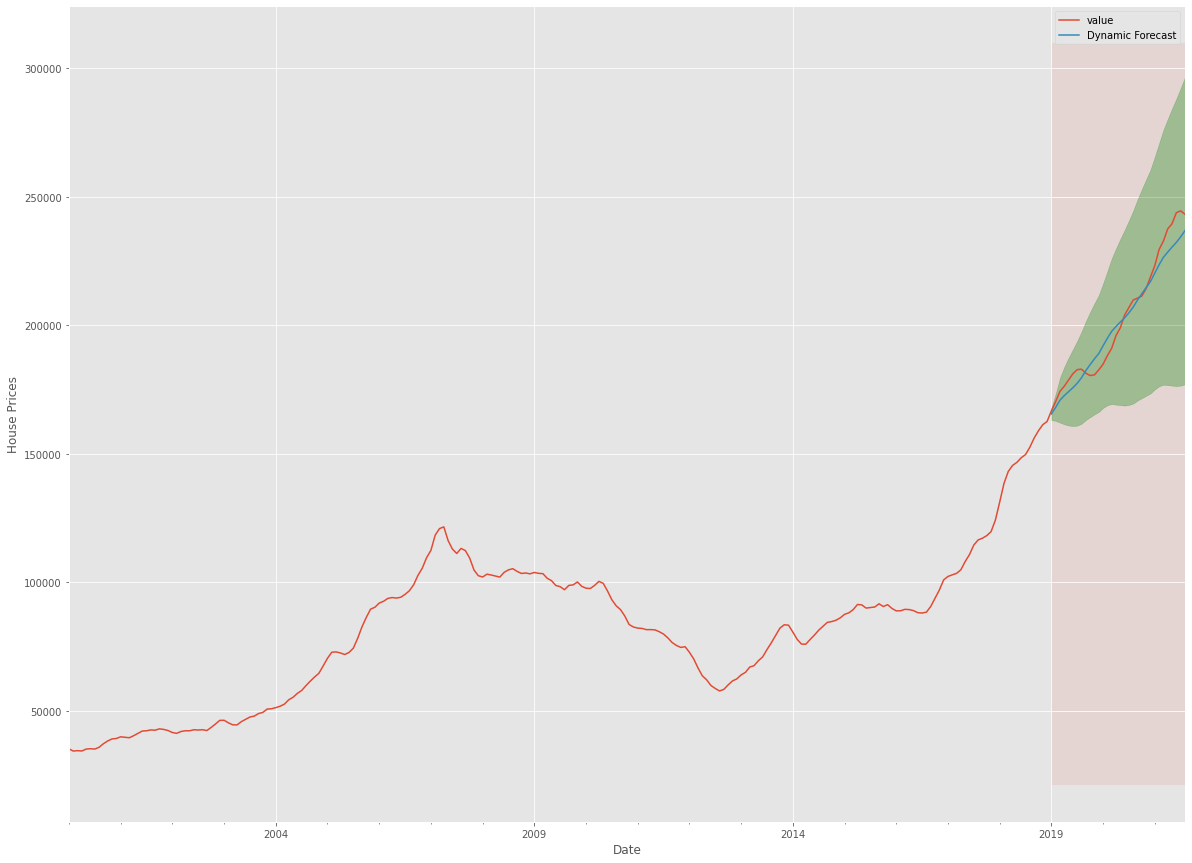

In [64]:
# Plot the dynamic forecast with confidence intervals.

ax = df_19121.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-01-31'), df19121_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('House Prices')

plt.legend()
plt.show()

# Producing and Visualizing Forecasts

In [65]:

# Get forecast 100 steps ahead in future
prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

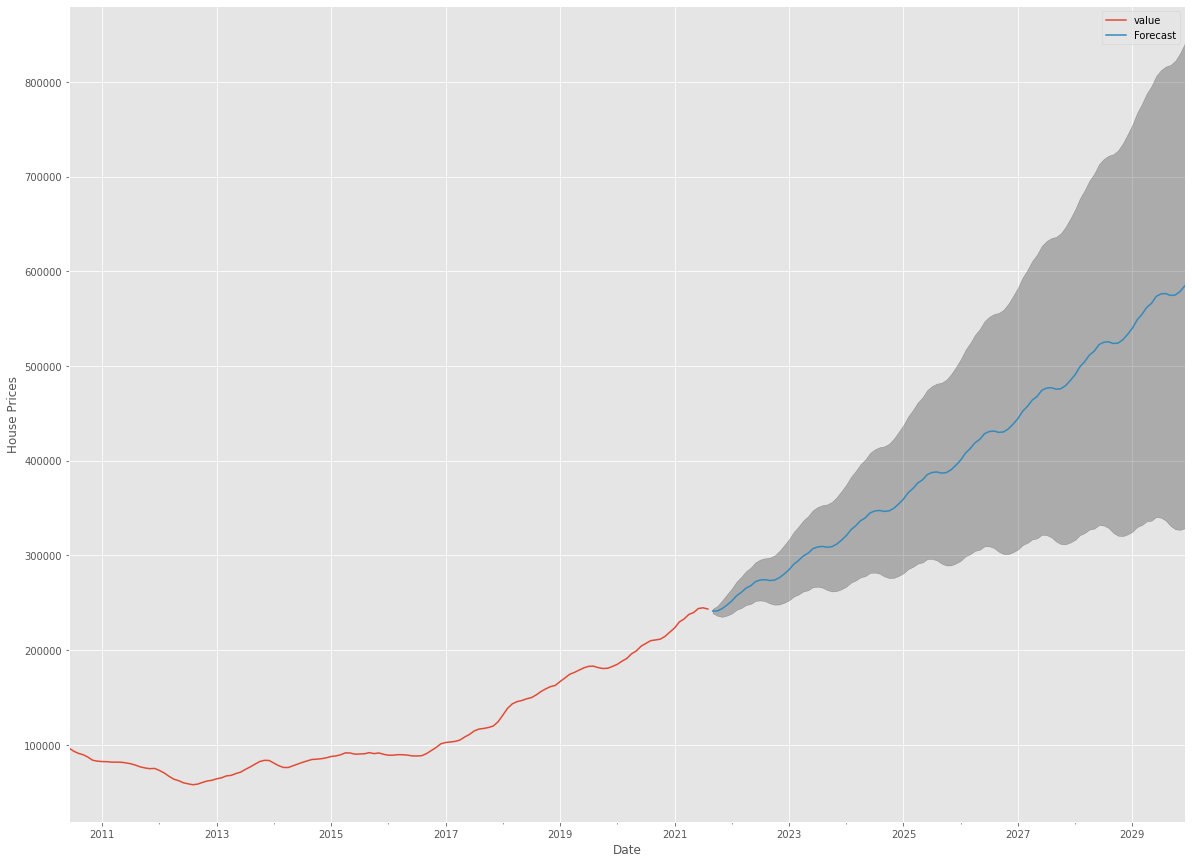

In [67]:
# Plot future predictions with confidence intervals
ax = df_19121.iloc[125:].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Prices')

plt.legend()
plt.show()